## Phantom Simulation

**Goal for the week (11 - 17 Jan.):** \
• Use the Shepp-Logan phantom package \
• Do a 2D Fourier transform of the array \
• Bunus point: add an image shift

In [11]:
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt

### 0. Functions

In [17]:
def shift_2d_array(arr_in, rl_shift, ud_shift):
#input: arr_in (input array), rl_shift (shift to right(+ve)/left(-ve) by how many pixels), ud_shift (shift upwards(+ve)/downwards(-ve) by how many pixels)
    rows, cols = arr_in.shape #get array size
    
    arr_rl_shifted = np.zeros_like(arr_in)
    arr_out = np.zeros_like(arr_in)

    #rightward/leftward shift
    for i in range(rows):
        arr_rl_shifted[i, rl_shift:] = arr_in[i, :-rl_shift]
        
    #upward/downward shift
    for i in range(rows - ud_shift):
        arr_out[i, :] = arr_rl_shifted[i + ud_shift, :]

    return np.array(arr_out, dtype = float)

In [18]:
#create 500*500 phantom image
phantom_img = sp.shepp_logan([500,500], float)

#Apply a 2D transformation on the image
phantom_kspace = np.fft.fftshift(np.fft.fft2(phantom_img))
magnitude_spectrum = np.log(np.abs(phantom_kspace) + 1) # Compute the magnitude spectrum (log-scaled for better visualization)

<function matplotlib.pyplot.show(close=None, block=None)>

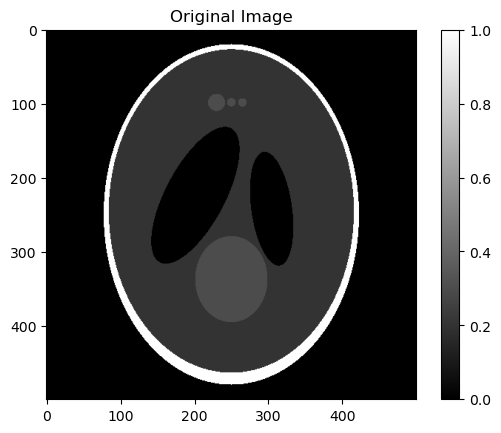

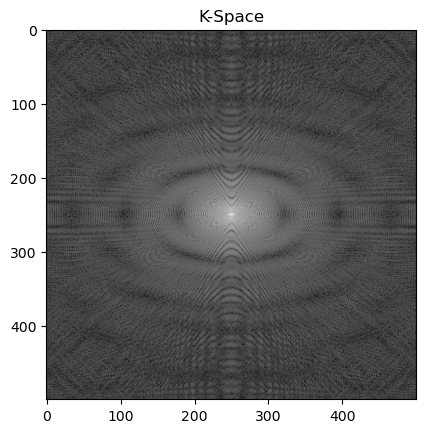

In [19]:
#plot phatom image in image space
plt.figure(1)
plt.imshow(phantom_img, cmap='gray')
plt.title('Original Image')
colorbar = plt.colorbar()

#plot magnitude spectrum in k-space
plt.figure(2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('K-Space')

plt.show

In [20]:
#shift phantom image (simulate motion)
shifted_phantom_img = shift_2d_array(phantom_img,200,100)

<function matplotlib.pyplot.show(close=None, block=None)>

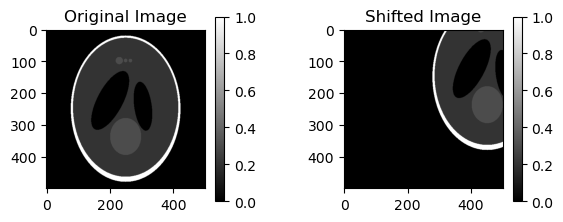

In [21]:
plt.subplot(121)
plt.imshow(phantom_img, cmap='gray')
plt.title('Original Image')
colorbar = plt.colorbar(shrink=0.5)

#plot magnitude spectrum in k-space
plt.subplot(122)
plt.imshow(shifted_phantom_img, cmap='gray')
plt.title('Shifted Image')
colorbar = plt.colorbar(shrink=0.5)

plt.subplots_adjust(wspace=0.5)

plt.show

In [27]:
#Apply a 2D transformation on the shifted image
shifted_phantom_kspace = np.fft.fftshift(np.fft.fft2(shifted_phantom_img))
shifted_magnitude_spectrum = np.log(np.abs(shifted_phantom_kspace) + 1)

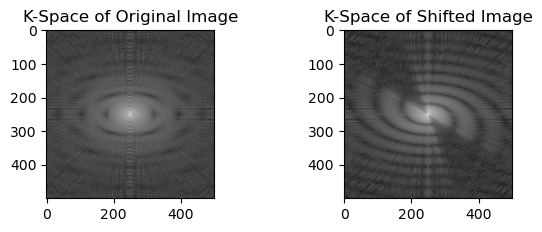

In [28]:
plt.subplot(221)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('K-Space of Original Image')


#plot magnitude spectrum in k-space
plt.subplot(222)
plt.imshow(shifted_magnitude_spectrum, cmap='gray')
plt.title('K-Space of Shifted Image')

plt.subplots_adjust(wspace=0.5)